# Collinear spin and magnetic systems

In this example we consider iron in the BCC phase.
To show that this material is ferromagnetic we will model it once
allowing collinear spin polarization and once without
and compare the resulting SCF energies. In particular
the ground state can only be found if collinear spins are allowed.

The `bulk(:Fe)` function from `AtomsBuilder` returns a BCC iron setup
with a single iron atom inside the unit cell.

In [1]:
using AtomsBuilder
using PseudoPotentialData
using DFTK

bulk(:Fe)

FlexibleSystem(Fe, periodicity = TTT):
    cell_vectors      : [  -1.435    1.435    1.435;
                            1.435   -1.435    1.435;
                            1.435    1.435   -1.435]u"Å"

    Atom(Fe, [       0,        0,        0]u"Å")


First we consider a setup without spin polarization.
To get the ground-state energy of this system we use an LDA model
and rather moderate discretisation parameters.

In [2]:
Ecut  = 15         # kinetic energy cutoff in Hartree
kgrid = [3, 3, 3]  # k-point grid (Regular Monkhorst-Pack grid)
pseudopotentials = PseudoFamily("cp2k.nc.sr.lda.v0_1.largecore.gth")

model_nospin  = model_DFT(bulk(:Fe); pseudopotentials, functionals=LDA(), temperature=0.01)
basis_nospin  = PlaneWaveBasis(model_nospin; kgrid, Ecut)
scfres_nospin = self_consistent_field(basis_nospin; tol=1e-4, mixing=KerkerDosMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -16.64986299088                   -0.48    6.0   99.0ms
  2   -16.65068799548       -3.08       -1.02    1.0    979ms
  3   -16.65081888156       -3.88       -2.30    1.8   17.3ms
  4   -16.65083405903       -4.82       -2.87    2.0   42.5ms
  5   -16.65083457791       -6.28       -3.41    1.8   15.9ms
  6   -16.65083463506       -7.24       -4.00    2.0   17.7ms
  7   -16.65083463716       -8.68       -4.40    1.2   14.7ms


In [3]:
scfres_nospin.energies

Energy breakdown (in Ha):
    Kinetic             15.9209763
    AtomicLocal         -5.0693755
    AtomicNonlocal      -5.2203106
    Ewald               -21.4723279
    PspCorrection       1.8758893 
    Hartree             0.7793601 
    Xc                  -3.4467585
    Entropy             -0.0182879

    total               -16.650834637163

Since we did not specify any initial magnetic moment on the iron atom,
DFTK will automatically assume that a calculation with only spin-paired
electrons should be performed. As a result the obtained ground state
features no spin-polarization.

Now we repeat the calculation, but give the iron atom an initial magnetic moment.
For specifying the magnetic moment pass the desired excess of spin-up over spin-down
electrons at each centre to the `Model` and the guess density functions.
In this case we seek the state with as many spin-parallel
$d$-electrons as possible. In our pseudopotential model the 8 valence
electrons are 1 pair of $s$-electrons, 1 pair of $d$-electrons
and 4 unpaired $d$-electrons giving a desired magnetic moment of `4` at the iron centre.
The structure (i.e. pair mapping and order) of the `magnetic_moments` array needs to agree
with the `atoms` array and `0` magnetic moments need to be specified as well.

In [4]:
magnetic_moments = [4];

> **Units of the magnetisation and magnetic moments in DFTK**
>
> Unlike all other quantities magnetisation and magnetic moments in DFTK
> are given in units of the Bohr magneton $μ_B$, which in atomic units has the
> value $\frac{1}{2}$. Since $μ_B$ is (roughly) the magnetic moment of
> a single electron the advantage is that one can directly think of these
> quantities as the excess of spin-up electrons or spin-up electron density.

We repeat the calculation using the same model as before. DFTK now detects
the non-zero moment and switches to a collinear calculation.

In [5]:
model = model_DFT(bulk(:Fe); pseudopotentials, functionals=LDA(),
                  temperature=0.01, magnetic_moments)
basis = PlaneWaveBasis(model; Ecut, kgrid)
ρ0 = guess_density(basis, magnetic_moments)
scfres = self_consistent_field(basis, tol=1e-6; ρ=ρ0, mixing=KerkerDosMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Magnet   Diag   Δtime
---   ---------------   ---------   ---------   ------   ----   ------
  1   -16.66155668310                   -0.51    2.617    5.8   54.5ms
  2   -16.66821598651       -2.18       -1.10    2.443    1.5    589ms
  3   -16.66906733285       -3.07       -2.08    2.341    2.2   34.3ms
  4   -16.66910822668       -4.39       -2.52    2.305    1.2   36.2ms
  5   -16.66911236329       -5.38       -2.82    2.298    1.5   29.3ms
  6   -16.66911408746       -5.76       -3.38    2.288    1.5   59.2ms
  7   -16.66911419760       -6.96       -3.80    2.286    2.0   34.5ms
  8   -16.66911420257       -8.30       -4.28    2.286    1.5    292ms
  9   -16.66911420353       -9.01       -4.63    2.286    1.8   32.1ms
 10   -16.66911420358      -10.36       -5.15    2.286    1.5   30.3ms
 11   -16.66911420358      -11.31       -5.70    2.286    2.0   34.1ms
 12   -16.66911420358   +  -11.29       -6.26    2.286    1.6   40.8ms


In [6]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             16.2947704
    AtomicLocal         -5.2227292
    AtomicNonlocal      -5.4100658
    Ewald               -21.4723279
    PspCorrection       1.8758893 
    Hartree             0.8191978 
    Xc                  -3.5406876
    Entropy             -0.0131612

    total               -16.669114203577

> **Model and magnetic moments**
>
> DFTK does not store the `magnetic_moments` inside the `Model`, but only uses them
> to determine the lattice symmetries. This step was taken to keep `Model`
> (which contains the physical model) independent of the details of the numerical details
> such as the initial guess for the spin density.

In direct comparison we notice the first, spin-paired calculation to be
a little higher in energy

In [7]:
println("No magnetization: ", scfres_nospin.energies.total)
println("Magnetic case:    ", scfres.energies.total)
println("Difference:       ", scfres.energies.total - scfres_nospin.energies.total);

No magnetization: -16.650834637163257
Magnetic case:    -16.66911420357696
Difference:       -0.018279566413703208


Notice that with the small cutoffs we use to generate the online
documentation the calculation is far from converged.
With more realistic parameters a larger energy difference of about
0.1 Hartree is obtained.

The spin polarization in the magnetic case is visible if we
consider the occupation of the spin-up and spin-down Kohn-Sham orbitals.
Especially for the $d$-orbitals these differ rather drastically.
For example for the first $k$-point:

In [8]:
iup   = 1
idown = iup + length(scfres.basis.kpoints) ÷ 2
@show scfres.occupation[iup][1:7]
@show scfres.occupation[idown][1:7];

(scfres.occupation[iup])[1:7] = [1.0, 0.9999987814934412, 0.9999987814934412, 0.9999987814934412, 0.958226001377246, 0.9582260013772462, 1.1263312002961098e-29]
(scfres.occupation[idown])[1:7] = [1.0, 0.8438931402461387, 0.8438931402460574, 0.843893140246105, 8.140669932211483e-6, 8.140669932209937e-6, 1.6227903756347863e-32]


Similarly the eigenvalues differ

In [9]:
@show scfres.eigenvalues[iup][1:7]
@show scfres.eigenvalues[idown][1:7];

(scfres.eigenvalues[iup])[1:7] = [-0.06935783616691071, 0.35688630041531566, 0.35688630041531594, 0.35688630041531744, 0.46173703847992265, 0.4617370384799226, 1.1596251547580994]
(scfres.eigenvalues[idown])[1:7] = [-0.031256718282239505, 0.4761902829992634, 0.4761902829992696, 0.47619028299926597, 0.6102514334363511, 0.610251433436353, 1.2250508925844872]


> **$k$-points in collinear calculations**
>
> For collinear calculations the `kpoints` field of the `PlaneWaveBasis` object contains
> each $k$-point coordinate twice, once associated with spin-up and once with down-down.
> The list first contains all spin-up $k$-points and then all spin-down $k$-points,
> such that `iup` and `idown` index the same $k$-point, but differing spins.

We can observe the spin-polarization by looking at the density of states (DOS)
around the Fermi level, where the spin-up and spin-down DOS differ.

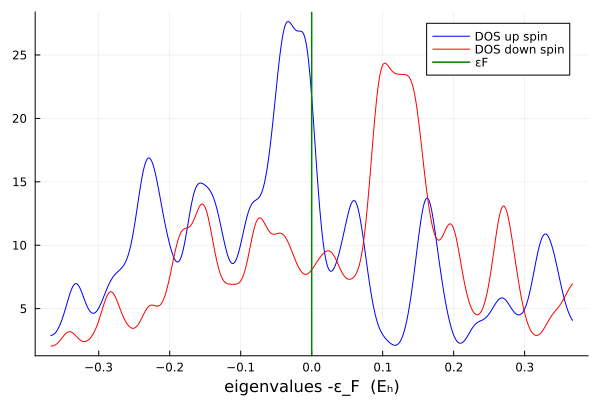

In [10]:
using Plots
bands_666 = compute_bands(scfres, MonkhorstPack(6, 6, 6))  # Increase kgrid to get nicer DOS.
plot_dos(bands_666)

Note that if same k-grid as SCF should be employed, a simple `plot_dos(scfres)`
is sufficient.

Similarly the band structure shows clear differences between both spin components.

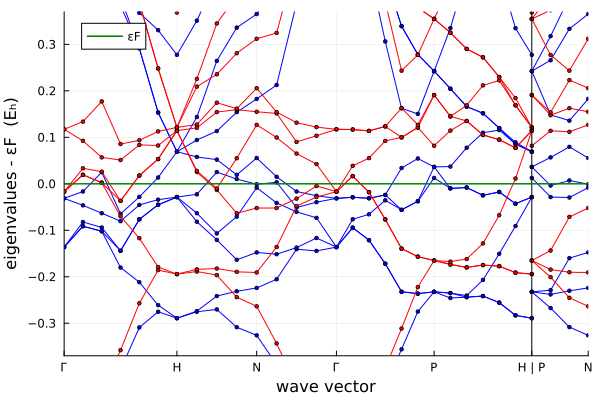

In [11]:
using Unitful
using UnitfulAtomic
bands_kpath = compute_bands(scfres; kline_density=6)
plot_bandstructure(bands_kpath)